# Management and Analysis of Physics Datasets

## Session I

#### Part A

```
$ ssh aperin@gate.cloudveneto.it


$ ssh root@10.67.22.14


$ cd /tmp/redis-5.0.5/src


$ ./redis-server &

[1] 2402
[root@lcp-1 src]# 2402:C 10 Jul 2019 17:37:03.730 # oO0OoO0OoO0Oo Redis is starting oO0OoO0OoO0Oo
2402:C 10 Jul 2019 17:37:03.730 # Redis version=5.0.5, bits=64, commit=00000000, modified=0, pid=2402, just started
2402:C 10 Jul 2019 17:37:03.730 # Warning: no config file specified, using the default config. In order to specify a config file use ./redis-server /path/to/redis.conf
2402:M 10 Jul 2019 17:37:03.730 * Increased maximum number of open files to 10032 (it was originally set to 1024).
2402:M 10 Jul 2019 17:37:03.731 # Could not create server TCP listening socket *:6379: bind: Address already in use

[1]+  Exit 1                  ./redis-server


$ ps -elf | grep redis

0 S root      2406  2334  0  80   0 - 28177 pipe_w 17:37 pts/2    00:00:00 grep --color=auto redis
4 S root     10785     1  0  80   0 - 347465 ep_pol Jul04 ?       00:07:38 ./redis-server *:6379


$ su andreaperin


$ export PATH=/tmp/redis-5.0.5/src:$PATH


$ redis-cli


$ quit

```

#### Part B

First, sourcing the `cloud.sh` file by 

`source cloud.sh`

Then:

**Exercise 3.1.1:**

```
sha1string /etc/passwd
63ce9c1433c0fad87dcc9d5d22081acc7ff60df4
```


**Exercise 3.1.2:**

A 4-bit hexadecimal number can take values in `[0x0 .. 0xF]`. We want to map this to `[1,2,3,4,5,6,7,8]`, in such a way that [0,1]->1, [2,3]->2 and so on.
This can be done by taking only the three most significant bits in the hexadecimal numbers; alternatively, just by dividing the decimal value of the number and then adding 1:

```
function h8d { 
    # args: <hex value> 
    echo "obase=10; ibase=16; $( echo "$*/2+1" | sed -e 's/0x//g' -e 's/\([a-z]\)/\u\1/g' )" | bc; 
}
```
**Exercise 3.1.3:**

Assign the `sha1` value of the string `/etc/passwd` to a variable named `hash`.

```
hash=hash=`sha1string /etc/passwd`
echo $hash
63ce9c1433c0fad87dcc9d5d22081acc7ff60df4

```

**Exercise 3.1.4:**

Extract the first letter of the variable `hash` from 3.1.3 and store it in a variable `hashkey`.

```
hashkey=`echo ${hash:0:1}`
echo $hashkey
6

```

**Exercise 3.1.5:**

Get the hashvalue using the `h8d` function for the variable `hashkey` from 3.1 4.

```
h8d $hashkey
4

```

**Exercise 3.1.6**

Use the `upload` function to upload the file `/etc/resolv.conf` according to the computed `hashvalue` and use the original filename as target name for the upload. To which server name/port/db is your file uploaded?

The `upload` function takes the following as input: the name of the file to upload, the key correpsonding to the disk where we want to upload and the name we want to assign to the newly uploaded file. Then:
```
filename="/etc/resolv.conf"
hash=`sha1string /etc/passwd`
hashkey=${hash:0:1}
index=`h8d $hashkey`

upload $filename $index $filename

```
Since
```
echo $index
3
```
the file is saved on db 3.



**Exercise 3.1.7**

Use the `download` function to download the previous uploaded file to a new local filename!

The `download` function takes the following arguments as input: the hash value (which can go from 1 to 8, it is the key of the location), the source name (which is the name of the file in the storage node), and the target name (the target file name on the local file system). Then:

```
newfilename="/home/andreaperin/resolv.conf.download"
download $index $filename $newfilename 
# downloaded /home/andreaperin/resolv.conf.download with size=134
```

**Exercise 3.1.8**

Use the list function to list all files on the server where you uploaded the file in 3.1.6.


The function `list` requires the index of the location as input, and it returns its contents. Then:

```
list $index

```

**Exercise 3.1.9**

Use the `delete` function to remove the uploaded file from 3.1.6.


The `delete` function takes a hash value as the index of the location on which to erase the file, and the name of the file to erase. Then:


```
delete $index $filename
```

**Exercise 3.1.10**

In the following we are going to implement now high-level functions to store, retrieve, list and delete files in our Cloud Storage system.

- cloud_upload
- cloud_download
- cloud_rm
- cloud_ls

These functions are already defined in the cloud library. On top of each function there is an exact description what they are supposed to do and which arguments to provide. Your task is mainly to prepare the arguments to call the corresponding low-level functions `upload download list rm` to implement a scalable cloud storage system.


Using a 1kB file, uploaded 100 times with different random names,

```
dd if=/dev/urandom of=/home/andreaperin/passwd bs=1000 count=1

1+0 records in
1+0 records out
1000 bytes (1.0 kB) copied, 0.000190984 s, 5.2 MB/s

for ((i=1;i<=100;i++)); do cloud_upload /home/andreaperin/passwd `uuidgen`; done

```

In order to empty the server, we use
```
redis-cli -h `hostmap 1` -p `portmap 1` -n `dbmap 1` FLUSHALL
```


**Exercise 3.1.11**

Implement now the `cloud_download` function which downloads the DHT distributed file to the local file system.


```
function cloud_download() {
   # check that the target is not yet existing
   if [ -f "$2" ]; then
      echo "error: target exists";
      return 1;
   fi

   hash=`sha1string $1`;
   hashkey=${hash:0:1}
   hashvalue=`h8d $hashkey`;
   echo "==> Downloading $1 with hash $hash from DHT location $hashvalue"
   download $hashvalue $1 $2

   # check if something was actually downloaded
   if [ ! -f $2 ]; then
      echo "error: download failed";
      return 1;
   fi
}

```

**Exercise 3.1.12**

Now count the number of files per KV server. How is the balancing of the distribution? How will the distribution evolve if we upload more and more files?

The command to use is a `for` loop over the various DB names, where the output is to be pipelined using `| wc -l`. Then:

```
for i in 1 2 3 4 5 6 7 8; do list $i | wc -l; done
```
as this groups files by their belonging to a specific DB.


**Exercise 3.1.13**

Implement the function `cloud_rm`.

```
function cloud_rm() {
   hash=`sha1string $1`;
   hashkey=${hash:0:1}
   hashvalue=`h8d $hashkey`;
   echo "==> Deleting $1 with hash $hash from DHT location $hashvalue"
   delete $hashvalue $1
}
```


**Exercise 3.1.14**

Implement the function `cloud_ls` and verify the listing. How many files do you see? Measure the time of the command using `time`.

```
function cloud_ls() {
   tmpfile="/tmp/.cloud_ls.$RANDOM"
   for name in 1 2 3 4 5 6 7 8; do
      list $name >> $tmpfile
   done
   sort $tmpfile
   unlink $tmpfile
}
```
In order to actually count, we can pipeline the output of `cloud_ls` using the `| wc -l` option. Then:
```
cloud_ls | wc -l
```
The timing is simply 
```
time cloud_ls
```

#### Part C

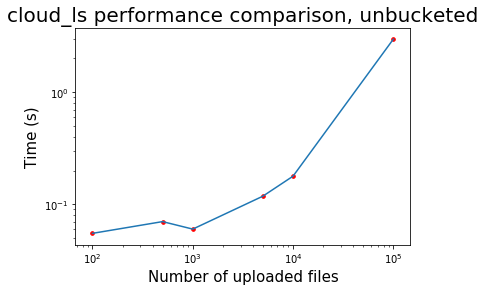

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


num_files = np.array([100,   500,   1000,  5000, 10000, 100000])
timing = np.array([  0.055, 0.070, 0.060, 0.118, 0.178, 2.970])

title="cloud_ls performance comparison, unbucketed"
figsize=(12,10)
labsize=15
titlesize=20

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(title, fontsize=titlesize)
ax.plot(num_files, timing)
ax.scatter(num_files, timing, s=13, color='r')
ax.set_xlabel("Number of uploaded files", fontsize=labsize)
ax.set_ylabel("Time (s)", fontsize=labsize)
ax.set_title(title, fontsize=titlesize)
plt.show()

The scaling properties of the algorithm seem good up until 10000 elements. However, when dealing with 100000 elements, the performance takes a noticeable hit and the process of listing becomes many times slower. In fact, a 10-times larger DB is listed in approximately 20 times longer time.

#### Part D

In order to upload the 1M files, and at the same producing a file with all the times in it, the following loop may be used:
```
redis-cli -h `hostmap 1` -p `portmap 1` -n `dbmap 1` FLUSHALL
TIMEFORMAT=%R
for ((i=0;i<=1000000;i++))
do { time cloud_upload /home/andreaperin/passwd `uuidgen` ; } 2>> /home/andreaperin/a.a 2>&2
done
```

All the times will then be concatenated in the file `a.a`. Only the times are saved, as is denoted by the syntax: the number 2 refers to the output of the `time` function; the result of the `cloud_upload`, which would be denoted by the 1, is instead discarded as it is not useful for our purpose. The concatenation happens between the timings, as denoted by `>>2`, so that only the times are concatenated. The `2>&2` part means that the output is redirected where the previous was directed, that means, towards `a.a`.

In the following, the file is processed, and the times plotted as function of the number of files.

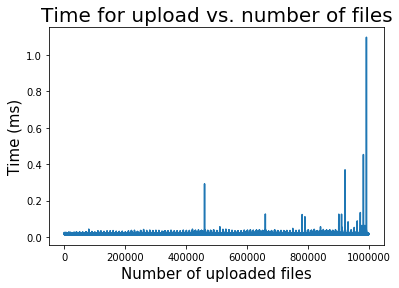


The average time for an uploa is 0.016 s, and its std is 0.002 s.


In [57]:
# using numpy to process the file with the times
path = "https://raw.githubusercontent.com/Andrea-Perin/ManagementPhysicsData/master/times_unbuck.txt"
title = "Time for upload vs. number of files"
times = pd.read_csv(path, header=None).T.values.reshape(1000001)
id_file = np.arange(1000001)+1


fig, ax = plt.subplots()
ax.set_title(title, fontsize=titlesize)
ax.plot(id_file, times)
ax.set_xlabel("Number of uploaded files", fontsize=labsize)
ax.set_ylabel("Time (ms)", fontsize=labsize)
ax.set_title(title, fontsize=titlesize)
plt.show()


print()
print("The average time for an upload is %.3f" %np.mean(times),"s, and its std is %.3f" %np.std(times),"s.")

Repeating the same plot that was done in Part C with the added bunch of files, the following can be seen.

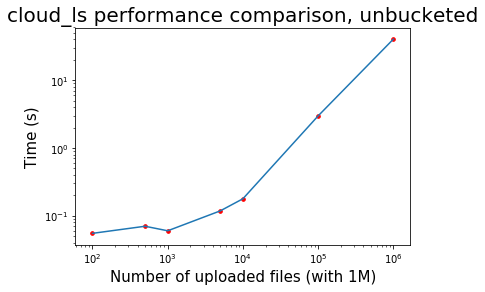

In [45]:
num_files = np.append(num_files, 1e6)
timing =  np.append(timing, 40.269)
title = "cloud_ls performance comparison, unbucketed"


fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(title, fontsize=titlesize)
ax.plot(num_files, timing)
ax.scatter(num_files, timing, s=13, color='r')
ax.set_xlabel("Number of uploaded files (with 1M)", fontsize=labsize)
ax.set_ylabel("Time (s)", fontsize=labsize)
ax.set_title(title, fontsize=titlesize)
plt.show()

#### Part E

**Question 1**

The implementatiom of a bucket system would improve the performances. Indeed, when we require the listing of the contents with the `cloud_ls` function, we are requiring the complete information across all DBs at the same time. The system tries to give the information in one go, and of course this impacts the prformance. The implementation of a bucket system allows the listing to happen on smaller subsets of the storage (the buckets) which allows for much better performance. Such implementation takes place by modifying the high level functions `cloud_upload`, `cloud_ls` and `cloud_rm`.

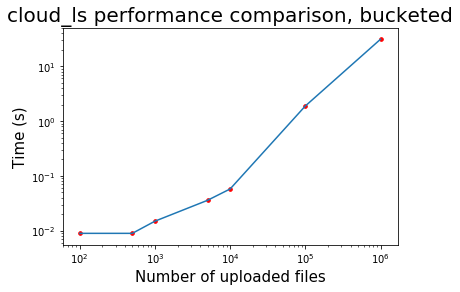

In [46]:
# repeating the previous steps with a bucket system
num_files = np.array([100,   500,  1000,   5000, 10000, 100000, 1000000])
timing_b = np.array([0.009, 0.009, 0.015, 0.036, 0.058, 1.888,  31.116]) # to add last step

title="cloud_ls performance comparison, bucketed"
figsize=(12,10)
labsize=15
titlesize=20

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(title, fontsize=titlesize)
ax.plot(num_files, timing_b)
ax.scatter(num_files, timing_b, s=13, color='r')
ax.set_xlabel("Number of uploaded files", fontsize=labsize)
ax.set_ylabel("Time (s)", fontsize=labsize)
ax.set_title(title, fontsize=titlesize)
plt.show()

A better comparison between the bucketed/unbucketed cases is shown below, where the two plots are superimposed.

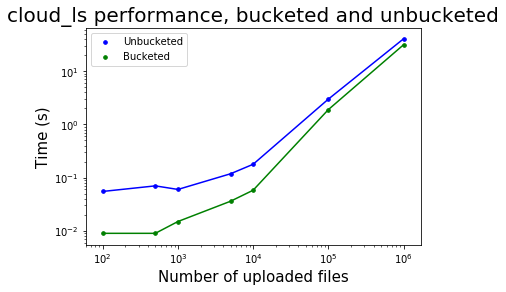

In [47]:
title="cloud_ls performance, bucketed and unbucketed"
figsize=(12,10)
labsize=15
titlesize=20

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(title, fontsize=titlesize)

ax.plot(num_files, timing, color='blue')
ax.scatter(num_files, timing, s=13, color='blue', label='Unbucketed')

ax.plot(num_files, timing_b, color='green')
ax.scatter(num_files, timing_b, s=13, color='green', label="Bucketed")

ax.set_xlabel("Number of uploaded files", fontsize=labsize)
ax.set_ylabel("Time (s)", fontsize=labsize)
ax.set_title(title, fontsize=titlesize)
plt.legend()
plt.show()

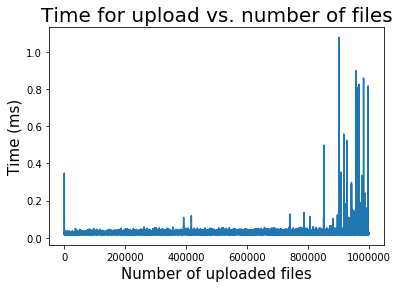


The average time for an upload (in the bucketed case) is 0.023 s, and its std is 0.004 s.


In [56]:
# using numpy to process the file with the times
path = "https://raw.githubusercontent.com/Andrea-Perin/ManagementPhysicsData/master/times.txt"
title = "Time for upload vs. number of files"
titlesize, labsize = 20, 15
times = pd.read_csv(path, header=None).T.values.reshape(1000000)
num_files = np.arange(1000000)+1

fig, ax = plt.subplots()
ax.set_title(title, fontsize=titlesize)
ax.plot(num_files, times)
ax.set_xlabel("Number of uploaded files", fontsize=labsize)
ax.set_ylabel("Time (s)", fontsize=labsize)
ax.set_title(title, fontsize=titlesize)
plt.show()


print()
print("The average time for an upload (in the bucketed case) is %.3f" %np.mean(times),"s, and its std is %.3f" %np.std(times),"s.")

The upload times stay pretty stable around the value of ~20 ms for the larger part. However, as time goes on, the upload times begin to spike, and the average increases a lot. In the end, the times spike very frequently. This could be a signal that the uploading starts having difficulties in finding appropriate slots for the files. The moving average may help identifying this behavior better.

Text(0.5, 1.0, 'Time for upload vs. number of files, smoothed')

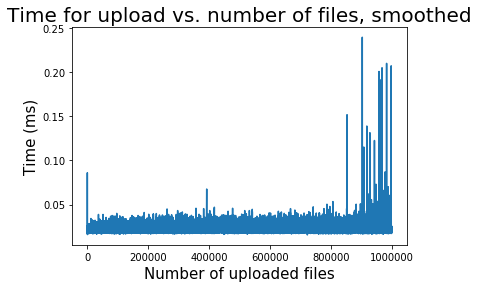

In [49]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

window = 5
rolltimes = moving_average(times, window)
title = 'Time for upload vs. number of files, smoothed'

fig, ax = plt.subplots()
ax.set_title(title, fontsize=titlesize)
ax.plot(num_files[:-window+1], rolltimes)
ax.set_xlabel("Number of uploaded files", fontsize=labsize)
ax.set_ylabel("Time (s)", fontsize=labsize)
ax.set_title(title, fontsize=titlesize)

**Question 2**

With an overhead of 1 s for each operation, the whole process would take an unbearable amount of time. In the case of the million files, we would end up with ~270 hours of wait time (plus the already present 4 hours of simple upload). A way to reduce the impact of this security overhead would be to allow a group of operations to be authorized by a single security check. This would reduce the number of overhead opearions and lead to a bearable time increase.

With the added overhead,

```
for ((i=0;i<=10;i++))
do time (cloud_upload /home/andreaperin/passwd `uuidgen` ; sleep 1) 2>> overhead_times.a 2>&2
done
```

the times are greatly increased.

If instead one was to have a unique security overhead, the `sleep 1` would be outside the `for` loop, thus leading to better timings. Only the upload of 100 files was tried.

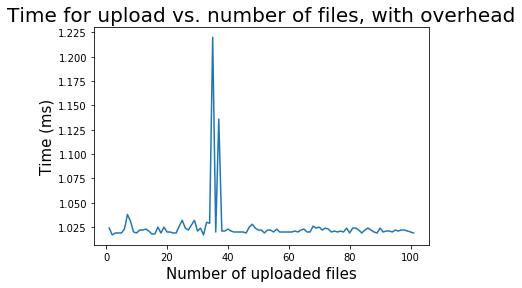


The average time for an upload (in the bucketed case) is 1.025 s, and its std is 0.023 s.

The total time for uploading all 100 files is 103.54 s.
The total time for uploading 5000 files (with no overhead) is 108.59 s.


In [64]:
path = 'https://raw.githubusercontent.com/Andrea-Perin/ManagementPhysicsData/master/withsleep.txt'
title = "Time for upload vs. number of files, with overhead"
titlesize, labsize = 20, 15
times = pd.read_csv(path, header=None).T.values.reshape(101)
num_files = np.arange(101)+1

fig, ax = plt.subplots()
ax.set_title(title, fontsize=titlesize)
ax.plot(num_files, times)
ax.set_xlabel("Number of uploaded files", fontsize=labsize)
ax.set_ylabel("Time (ms)", fontsize=labsize)
ax.set_title(title, fontsize=titlesize)
plt.show()


print()
print("The average time for an upload (in the bucketed case) is %.3f" %np.mean(times),"s, and its std is %.3f" %np.std(times),"s.")
print()
print("The total time for uploading all 100 files is %.2f" %np.sum(times), "s.")
npath = 'https://raw.githubusercontent.com/Andrea-Perin/ManagementPhysicsData/master/nosleep.txt'
ntimes = pd.read_csv(npath, header=None).T.values.reshape(5001)
print("The total time for uploading 5000 files (with no overhead) is %.2f" %np.sum(ntimes), "s.")

The total time for the upload of 100 files with overhead is 103.5 s, while (for a simple comparison) the upload of 5000 files (without overhead) takes only ~5 seconds more. Of course, this kind of overhead makes even simple operations take a long time. If the overhead was to be applied only once, no such problem would arise: after the initial security check, all subsequent operations from that client (in that specific connection) would be processed normally.

**Question 3**

A possible way of improving the reliability of the service would be to implement a RAID-like system, with multiple copies of the data, spread over the various storage elements, and some checksums. This would require a modification in the uploading function, so that each upload gets copied a fixed amount of times and its parts spread over the various disks. Also, the computation of the additional copies should be implemented.

The most simple version of such a system would be to simply copy each uploaded file to multiple DBs. Even for such a simple system, however, special care should be taken in deciding:
* how many copies for each file;
* where to store the additional copies;
* from which storage unit to retrieve a file;
* how to erase an uploaded file, i.e., finding all instances of that file;
* how to redirect requests in case of failure of one particular storage unit, and how to restore data on it.

## Session II

#### Part A

Both the GRID and Cloud architectures are based on a system of layers, which have different roles and features, and are interconnected in order to empower the respective framework.

In the case of GRID, there are 5 different layers: these are called **fabric**, **connectivity**, **resource**, **collective** and **application**. 
- By fabric layer, we denote the set of hardware components (both computing power and storage units), network resources and code repositories that allow the basic implementation of all higher level layers. This is the most "physical" part of the GRID framework. 
- The connectivity layer is a software layer which comprises the various authorization and authentication protocols that empower safe and reliable network transactions. Due to the distributed nature of GRID, this layer is composed of both local level and global level protocols. 
- The resource layer is a software layer that defines protocols for data access, publication and sharing; it also involves priority (which jobs get to be done first), monitoring (who does what) and accounting (tracing the aresource usage in order to calculate the appropriate costs for each user).
- The collective layer has the role of directing interactions between resources; it deals with scheduling, directory brokering, diagnostics/monitoring and so on. These are not linked to any one particular resource, but rather to the whole set of resources.
- The application layer denotes the set of software which actually allows the usage of the GRID services.

The Cloud, on the other hand, is made of **fabric**, **unified resource layer**, **platform** and **application**.
- The fabric layer denotes the same set of hardware, network and software resources in GRID's fabric layer. Indeed, both frameworks employ the same physical resources, as the data centers in which the hardware is placed are the same for both.
- The unified resource layer denotes the set of abstracted resources that can be used by higher layers. What this means is that, in the unified resource layer, many different resources are virtualized and made somewhat homogenous, as to allow a better integration. This results in virtual clusters, databse systems, logical file systems and so on.
- The platform layer comprises all the middleware that is based on the unified resource layer. This is the set of software which allows the development/deployment of applications. This could mean a web hosting environment, a scheduling service and so on.
- The application layer, similarly to the one that can be found in GRID's architecture, denotes the set of software through which an end user can take advantage of the Cloud services.

In light of these descriptions, one can find the basic differences between the two architecures. In a sense, the differences are in the middle. The fabric layer is pretty much the same, and the application layer has the same role, as it is the higher level layer in both architectures. 

In GRID, the three central layers are more focused on the coordination of many different resources in order to create a common system with a focus on scientific data handling. This is achieved through the definition of a system of communication and transaction protocols, a set of protocols designed specifically for data access and manipulation, and then an overlaying set of control software to direct the interactions between resources. The application layer then works with a wide and possibly heterogenous - but still, with effective communication - set of resources.

The Cloud, instead, is more focused on delivering a set of unified resources and common middleware in order to make developing applications easier. In a sense, the Cloud is more centralized and focused on delivering all its services in a mostly unifies way. This makes the division into a unified resource layer (that through virtualization makes all resources "equal") and a platform layer (which contains the middleware to operate on those unfied resources) very sensible.

#### Part B

##### Tasks 1-2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client

client = Client('192.168.1.102:8786')
client

/home/andrea/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/andrea/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Client Scheduler: tcp://192.168.1.102:8786 Dashboard: http://192.168.1.102:8787/status,Cluster Workers: 2 Cores: 2 Memory: 3.72 GB


In [2]:
import dask
import dask.dataframe as dd
url = "https://www.dropbox.com/s/75aqeywzxsu6hqt/dataset_sampled_handwritten.csv?dl=1"

dataset_raw = dd.read_csv(url)

In [3]:
dataset_raw.head()

,letter,label,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,pixel_784
0,t,19,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,w,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,w,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,e,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Task 3

In [4]:
count_letter = dataset_raw.letter.value_counts()

counts=count_letter.compute()

In [11]:
nice_format = pd.DataFrame([counts]).T.rename(index=str, columns={'letter':'counts'})
nice_format

,counts
o,7863
s,6400
u,3868
c,3201
t,2942
p,2588
n,2578
a,1871
m,1608
e,1606


##### Task 4

In [31]:
from time import time

n_reps = [2, 3, 4, 6]    # all multiples of 2, as there are two workers;
                                # a 3 is added just to see the differences

for i in n_reps:
    
    data_rep = dataset_raw.repartition(npartitions=i)
    
    start=time()
    
    count_letter = data_rep.letter.value_counts()
    count_letter.compute()

    finish=time()

    print("With", i, "repartitions, it took", finish-start, "seconds.\n")

With 2 repartitions, it took 132.55557084083557 seconds.

With 3 repartitions, it took 206.950834274292 seconds.

With 4 repartitions, it took 164.4395968914032 seconds.

With 6 repartitions, it took 126.17252683639526 seconds.



This, however, is just a bunch of single trials; they can be made more meaningful if repeated, so that an average and a standard deviation can be computed. Something that is immediately noticeable is that, with 3 repartitions, the performance is much worse.

In [32]:
n_reps = [2,4,6,8]
num_trials= 5
trial = []
    
for i in n_reps:
    
    for j in range(num_trials):

        data_rep = dataset_raw.repartition(npartitions=i)

        start=time()

        count_letter = data_rep.letter.value_counts()
        count_letter.compute()

        finish=time()
        
        trial.append(finish-start)
        
performance = np.array(trial)

KeyboardInterrupt: 

In [ ]:
performance.reshape(num_trials)
average = np.mean(performance, axis=1)
std = np.std(performace, axis=1)

title = "Performance vs. number of repartitions"
figsize=(12,10)
labsize=15
titlesize=20

fig, ax = plt.subplots()
ax.set_title(title, fontsize=titlesize)
ax.errorbar(n_reps, average, std)
ax.set_xlabel("Number of repartitions", fontsize=labsize)
ax.set_ylabel("Time (s)", fontsize=labsize)
ax.set_title(title, fontsize=titlesize)

##### Task 5

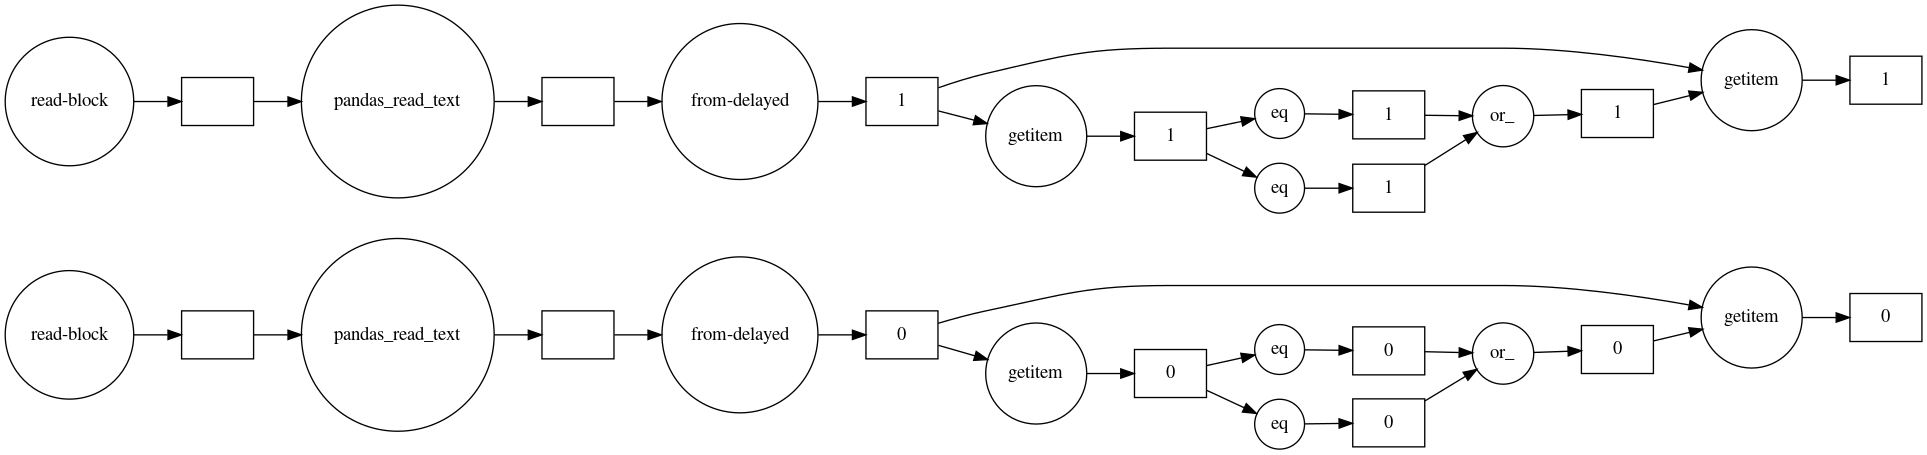

In [13]:
az = dataset_raw[(dataset_raw.letter=='a')|(dataset_raw.letter=='z')]

az.visualize(rankdir="LR")

Since the number of workers is set to 2, there are two separate and identical graphs.

Each of them start by reading a block and then going to the `pandas_read_text`; then, the first real computations start in order to perform the selection of the lines. This is done by evaluating the two equality conditions (which are the two `eq` blocks) and then passing them to the logical `or` operator. After that, the `getitem` comes into play.

This selection operation is easily parallelizable as each entry is independent from the others and all operations are identical for all entries.

##### Task 6

In [14]:
from dask_ml.model_selection import train_test_split

In [15]:
X = az.drop(['letter', 'label'], axis=1).compute()
y = az.label.compute()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

Mixture of types in 'arrays'. Falling back to scikit-learn.


##### Task 7

In [ ]:
from sklearn.neural_network import MLPClassifier
from dask_ml.wrappers import ParallelPostFit
from dask_ml.wrappers import Incremental
from dask_ml.preprocessing import MinMaxScaler

transformer = MinMaxScaler(feature_range=(0, 1), copy=True)
transformer.fit(X_train) # the transformer must be fit on the training, 
                         # as we do not have previous knowledge about the test set

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

estimator =  MLPClassifier(random_state=42, 
                          max_iter=1, 
                          hidden_layer_sizes=(200, 200 ), 
                          activation='relu', 
                          solver='adam', alpha=0.0001, 
                          batch_size='auto', 
                          learning_rate_init=0.001, 
                          shuffle=True, 
                          tol=0.0001, 
                          validation_fraction=0.1)

try:
    clf = Incremental(estimator)
    clf.fit(X_train, y_train, classes=[0, 1])
    clf = ParallelPostFit(estimator=clf.estimator_,scoring='accuracy')
    print("Accuracy: "+str(sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))))

except MemoryError as error:
    print("Memory error!!!")

##### Task 8

In [ ]:
# putting everything together from the previous cells
client = Client('192.168.1.102:8786')
client

In [ ]:
count_letter = dataset_raw.letter.value_counts()
counts=count_letter.compute()
nice_format = pd.DataFrame([counts]).T.rename(index=str, columns={'letter':'counts'})
nice_format

In [ ]:
n_reps = [2,4,6,8,10]
num_trials= 5
trial = []
    
for i in n_reps:
    
    for j in range(num_trials):

        data_rep = dataset_raw.repartition(npartitions=i)

        start=time()

        count_letter = data_rep.letter.value_counts()
        count_letter.compute()

        finish=time()
        
        trial.append(finish-start)
        
performance = np.array(trial)

# plotting

performance.reshape(num_trials)
average = np.mean(performance, axis=1)
std = np.std(performace, axis=1)

title = "Performance vs. number of repartitions"
figsize=(12,10)
labsize=15
titlesize=20

fig, ax = plt.subplots()
ax.set_title(title, fontsize=titlesize)
ax.errorbar(n_reps, average, std)
ax.set_xlabel("Number of repartitions", fontsize=labsize)
ax.set_ylabel("Time (s)", fontsize=labsize)
ax.set_title(title, fontsize=titlesize)

In [ ]:
az = dataset_raw[(dataset_raw.letter=='a')|(dataset_raw.letter=='z')]
az.visualize(rankdir="LR")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [ ]:
transformer = MinMaxScaler(feature_range=(0, 1), copy=True)
transformer.fit(X_train) # the transformer must be fit on the training, 
                         # as we do not have previous knowledge about the test set

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

estimator =  MLPClassifier(random_state=42, 
                          max_iter=1, 
                          hidden_layer_sizes=(200, 200 ), 
                          activation='relu', 
                          solver='adam', alpha=0.0001, 
                          batch_size='auto', 
                          learning_rate_init=0.001, 
                          shuffle=True, 
                          tol=0.0001, 
                          validation_fraction=0.1)

try:
    clf = Incremental(estimator)
    clf.fit(X_train, y_train, classes=[0, 1])
    clf = ParallelPostFit(estimator=clf.estimator_,scoring='accuracy')
    print("Accuracy: "+str(sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))))

except MemoryError as error:
    print("Memory error!!!")

The results are that my computer sucks major ass.

#### Task 9

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from dask_tensorflow import start_tensorflow
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import Flatten

tf_spec, dask_spec = start_tensorflow(client, ps=2, worker=2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

scaler = MinMaxScaler(feature_range = (0,0.5))
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def build_deep_cnn_neural_network():
    # create model
    
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3,3), name='c1', strides=(1, 1), 
                     padding='valid', activation='relu', input_shape=(64,64,3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(2,2), name='c2', strides=(1, 1), 
                     padding='valid', activation='relu', input_shape=(32,32,3)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu', name='d1'))
    model.add(Dropout(0.2))

    model.add(Dense(16, activation='relu', name='d3'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid', name='d4'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
X_train, X_test = X_train.reshape((len(X_train), 64,64, 3)),  X_test.reshape((len(X_test), 64,64, 3))

mycnn = build_deep_cnn_neural_network()
mycnn.fit(X_train, y_train, verbose=1, epochs=10, batch_size=32)

print(model.predict(X_test))

In [ ]:
scores = mycnn.evaluate(X_test,y_test, verbose=1)
print("Accuracy: "+str(scores[1]))